In [1]:
from os.path import dirname, abspath,join
from os import makedirs
import sys
import numpy as np
import pandas as pd
import json
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)
from proT.evaluation.predict import *

# plotting standard settings
plt.rcParams['figure.dpi'] = 100 #360 # standard is 360 but for set to 100 for practical visualization on the notebook
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['lines.linewidth'] = 1.5

## Load Experiment

In [37]:
datadir_path = r"../data/"
experiment = "Lie_attention_scm2"
config_path = join(r"../experiments",experiment,"config_v5_5.yaml")
checkpoint_path_list = [
    join(r"../experiments",experiment,"k_0/checkpoints/best_checkpoint.ckpt"),
    join(r"../experiments",experiment,"k_1/checkpoints/best_checkpoint.ckpt"),
    join(r"../experiments",experiment,"k_2/checkpoints/best_checkpoint.ckpt"),
    join(r"../experiments",experiment,"k_3/checkpoints/best_checkpoint.ckpt"),
    #join(r"../experiments",experiment,"k_4/checkpoints/best_checkpoint.ckpt"),
]

cross_att_list = []
enc_self_att_list = []
dec_self_att_list = []

for checkpoint_path in checkpoint_path_list:
    config = OmegaConf.load(config_path)
    results = predict_test_from_ckpt(
        config, 
        datadir_path, 
        checkpoint_path,
        dataset_label="test")

    # unpack
    input_array = results.inputs
    output_array = results.outputs
    target_array = results.targets
    cross_att_array = results.attention_weights["cross"] 
    enc_self_att_array = results.attention_weights["encoder"]
    dec_self_att_array = results.attention_weights["decoder"]
    cross_att_list.append(cross_att_array)
    enc_self_att_list.append(enc_self_att_array)
    dec_self_att_list.append(dec_self_att_array)

Seed set to 42


Dataset in one numpy file.
Input shape:  (50000, 2, 2)
Target shape:  (50000, 1, 2)
Dataset in one numpy file.
Input shape:  (50000, 2, 2)
Target shape:  (50000, 1, 2)
Test dataset selected.
Predicting...


100%|██████████| 157/157 [00:26<00:00,  5.89it/s]
Seed set to 42


Dataset in one numpy file.
Input shape:  (50000, 2, 2)
Target shape:  (50000, 1, 2)
Dataset in one numpy file.
Input shape:  (50000, 2, 2)
Target shape:  (50000, 1, 2)
Test dataset selected.
Predicting...


100%|██████████| 157/157 [00:05<00:00, 28.76it/s] 
Seed set to 42


Dataset in one numpy file.
Input shape:  (50000, 2, 2)
Target shape:  (50000, 1, 2)
Dataset in one numpy file.
Input shape:  (50000, 2, 2)
Target shape:  (50000, 1, 2)
Test dataset selected.
Predicting...


100%|██████████| 157/157 [00:05<00:00, 30.13it/s] 
Seed set to 42


Dataset in one numpy file.
Input shape:  (50000, 2, 2)
Target shape:  (50000, 1, 2)
Dataset in one numpy file.
Input shape:  (50000, 2, 2)
Target shape:  (50000, 1, 2)
Test dataset selected.
Predicting...


100%|██████████| 157/157 [00:05<00:00, 29.72it/s] 


In [38]:
def notears_acyclicity(A: torch.Tensor) -> torch.Tensor:
    """
    A: (d, d) adjacency matrix (non-negative entries)
    returns: scalar acyclicity penalty
    """
    d = A.shape[0]
    expm_A = torch.matrix_exp(A)
    return torch.trace(expm_A) - d

In [39]:
attention_maps = {
    0: {
        "output"    : enc_self_att_list,
        "target"    : "enc_sef_att_mask.csv"
    },
    1: {
        "output"    : cross_att_list,
        "target"    : "dec_cross_att_mask.csv"
    }
}

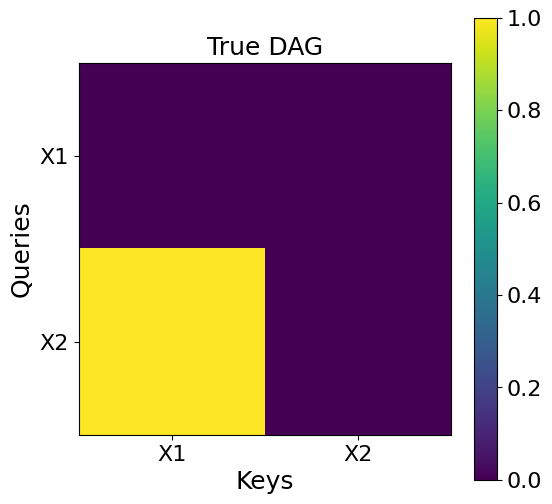

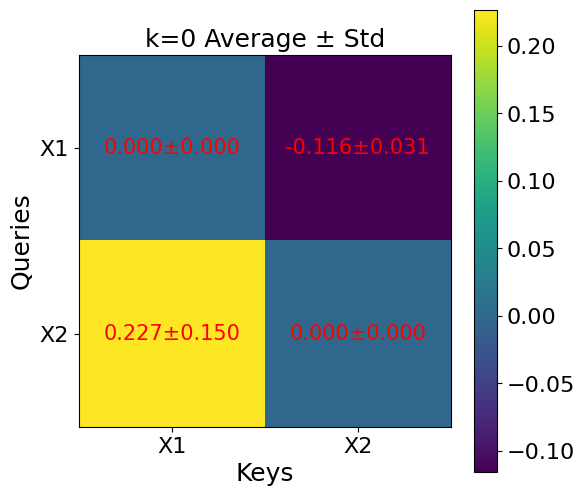

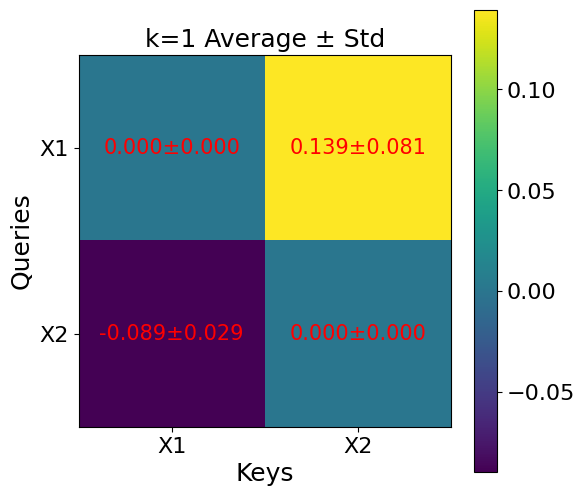

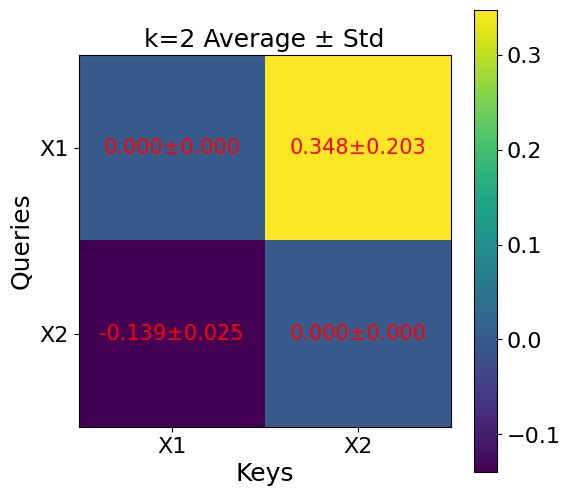

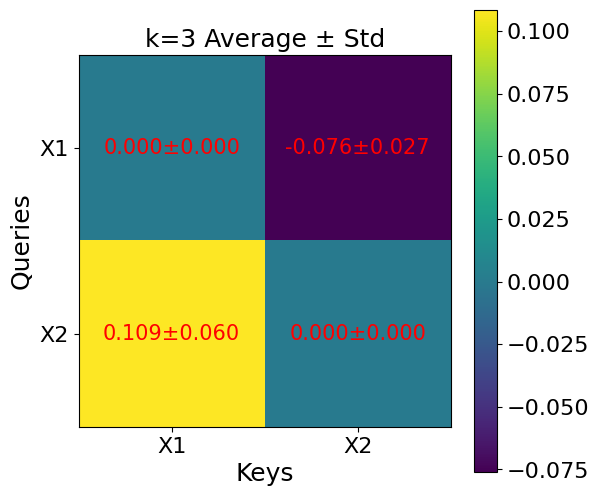

In [40]:
option = 0

idx_list = None#[0,1,2,3,4,5]
k_list = np.arange(len(checkpoint_path_list))

attention_list = attention_maps[option]["output"]


att_filename = attention_maps[option]["target"]
dataset_path = join(datadir_path, config.data.dataset)
data = pd.read_csv(join(dataset_path, att_filename), index_col="Unnamed: 0")
data_plot = pd.read_csv(join(dataset_path, att_filename),index_col=0).to_numpy()
y_ticks = data.index.to_numpy()
x_ticks = data.columns.to_numpy()




plt.figure()
plt.imshow(data_plot)
plt.colorbar()
plt.ylabel("Queries")
plt.xlabel("Keys")
plt.xticks(range(len(x_ticks)), x_ticks)
plt.yticks(range(len(y_ticks)), y_ticks)
plt.title(f"True DAG")

for k in k_list:
    attention_tensor = attention_list[k]
    
    if len(attention_tensor.shape) < 3:
        attention_tensor = np.expand_dims(attention_tensor, axis=1)
        
    assert len(attention_tensor.shape) == 3
    #print(notears_acyclicity(torch.tensor(attention_tensor.mean(axis=0)[:,:])))
    plt.figure()
    mean = attention_tensor.mean(axis=0)[:, :]
    std = attention_tensor.std(axis=0)[:, :]

    plt.imshow(mean)
    plt.colorbar()
    plt.title(f"k={k} Average ± Std")
    plt.ylabel("Queries")
    plt.xlabel("Keys")
    plt.xticks(range(len(x_ticks)), x_ticks)
    plt.yticks(range(len(y_ticks)), y_ticks)

    # Annotate each cell with mean ± std
    for i in range(mean.shape[0]):
        for j in range(mean.shape[1]):
            plt.text(
                j, i, f"{mean[i, j]:.3f}±{std[i, j]:.3f}",
                ha="center", va="center", color="r",fontsize=15)

    plt.show()
    
    if idx_list is not None:
        for idx in idx_list:
            plt.figure()
            plt.imshow(attention_tensor[idx,:,:])
            plt.colorbar()
            plt.title(f"k={k}, idx={idx}")
            plt.ylabel("Queries")
            plt.xlabel("Keys")